In [1]:
#Include holiday data for demand prediction using prophet
#refering https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
#!pip install fbprophet
#https://facebook.github.io/prophet/docs/installation.html
from fbprophet import Prophet
import holidays
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


Importing plotly failed. Interactive plots will not work.


In [4]:
member_daily=pd.read_csv('../dc/member_daily.csv') #done for member daily
casual_daily=pd.read_csv('../dc/casual_daily.csv') #done for member daily
print('Registed rides: ' + str(member_daily['number of users'].sum()))
print('Casual rides: ' + str(casual_daily['number of users'].sum()))
# print(member_daily.head())

data = pd.concat([member_daily, casual_daily], ignore_index=True)
# print(data.shape)

data= data.groupby(['date']).sum().reset_index()
print('Total rides: ' + str(data['number of users'].sum()))
data.to_csv(r'../data/daily_count.csv', index = False)

#print(data.head())
#print(data.shape)


Registed rides: 119530
Casual rides: 9984
Total rides: 129514


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


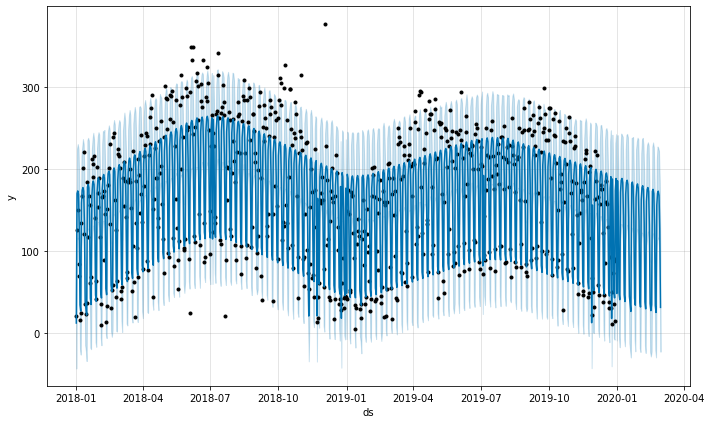

In [5]:

data['date']=pd.to_datetime(data['date'])
data['day']=data['date'].dt.day

data1=data[['date','number of users']]
data1.columns=['ds','y']

data_train=data1.iloc[0:-60,:]
data_test=data1.iloc[-60:,:]

model = Prophet()
#using inbuilt holidays
model.add_country_holidays(country_name='US')
model.fit(data_train)


future_data = model.make_future_dataframe(periods=60, freq = 'd')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

model.plot(forecast_data)
plt.show()




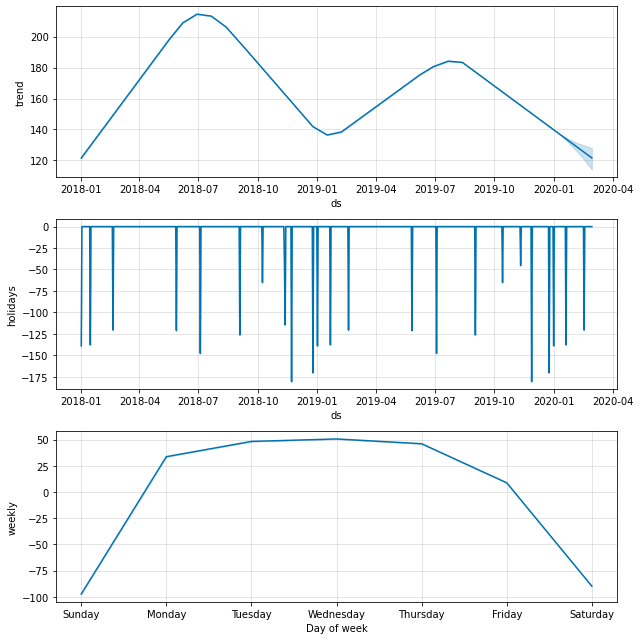

In [41]:
model.plot_components(forecast_data)
plt.show()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-03-11 00:00:00 and 2019-11-01 00:00:00


  horizon          mse       rmse        mae      mape     mdape  coverage
0  6 days  1972.257205  44.410103  33.344315  0.292473  0.133883  0.848485
1  7 days  2531.698993  50.315991  37.346253  0.323722  0.182199  0.803030
2  8 days  2987.716591  54.660009  40.649630  0.342298  0.210840  0.742424
3  9 days  3988.731232  63.156403  46.480329  0.471058  0.262367  0.681818
4 10 days  4890.510598  69.932186  51.789420  0.639483  0.313063  0.636364


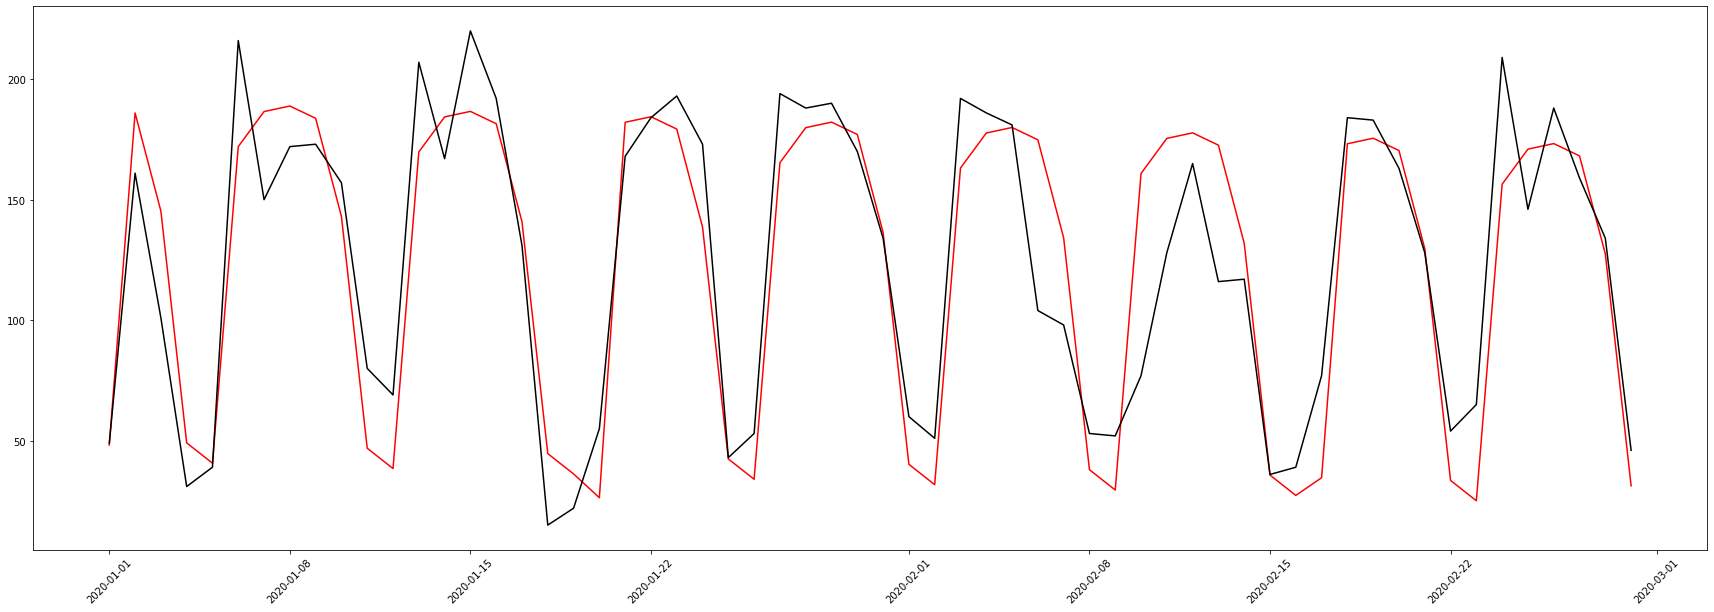

In [6]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(rotation=45)
plt.plot(forecast_data['ds'].iloc[-60:],forecast_data["yhat"].iloc[-60:],color='red')
plt.plot(data_test['ds'],data_test["y"],color='black')


from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='60 days', period='60 days', horizon = '60 days')
df_cv.head()

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print(df_p.head())

df_p.to_csv(r'../data/performance_metrics_with_holidays.csv', index = False)



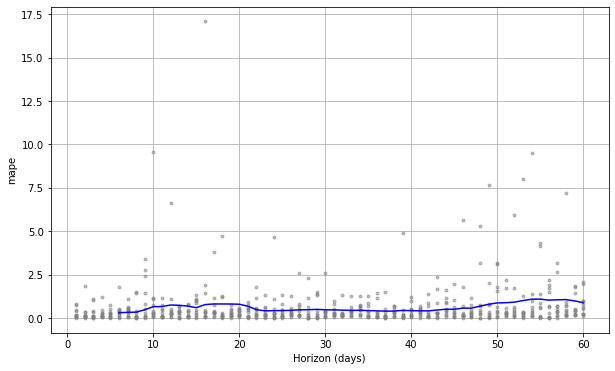

In [45]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

    horizon          mse       rmse        mae      mape     mdape  coverage
0   6 days   2540.585769  50.404224  37.824624  0.314059  0.207436  0.829726
1   7 days   2965.456647  54.456007  40.853953  0.336093  0.212705  0.786436
2   8 days   3273.242827  57.212261  43.045469  0.366666  0.232653  0.770563
3   9 days   4365.496124  66.071901  49.093393  0.495237  0.280404  0.702742
4  10 days   5274.794034  72.627777  54.583201  0.674866  0.311038  0.639250


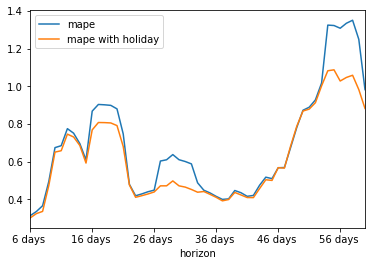

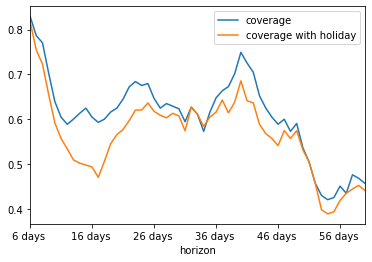

In [92]:
#mape vs horizon (6-10)
metric=pd.read_csv('../data/performance_metrics.csv') #done for member daily
metric_with_holidays=pd.read_csv('../data/performance_metrics_with_holidays.csv') #done for member daily
metric['horizon'] = metric['horizon'].map(lambda x: x[:-18])
metric_with_holidays['horizon'] = metric_with_holidays['horizon'].map(lambda x: x[:-18])
print(metric.head())

mape=metric[['horizon','mape']]
mape['mape with holiday'] = metric_with_holidays['mape']
mape.set_index('horizon', inplace=True)
#print(mape)

#print(mape['horizon'].iloc[0] in mape.index)

lines =mape.plot.line()
plt.savefig('../figures/compare_mape_holiday_effect.png')


coverage=metric[['horizon','coverage']]
coverage['coverage with holiday'] = metric_with_holidays['coverage']
coverage.set_index('horizon', inplace=True)
lines =coverage.plot.line()

plt.savefig('../figures/compare_coverage_holiday_effect.png')




In [ ]:
#coverage is less with holiday effect but mape is lower. 

# Could set upper, lower bounds per holidays, as below, this could be done if required at the end
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))